# **Autoencoder Model - Anomaly Detection**
### Group 8

### **__Comments__**

- **Model without finetuning**

- Model was a basic autoencoder architecture (could be tuned further)

- Evaluation methods need to be explored further

- Batch size was chosen as 64 because of it being the standard should be changed

- We need to create the (normalized) score values for the 

In [1]:
# Libraries
import json
from pandas import DataFrame
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Random state/seed
random_state = 42


In [2]:
features = open("features.json",)
data_dict=json.load(features)

In [3]:
def time_diff(features):
    for ip in features:
        for i in range(len(features[ip])):
            log_time=list(features[ip][i]["log_time"])
            if(i==0):
                features[ip][i]["time_diff"]=-1
            else:
                if((log_time[0]-features[ip][i-1]["log_time"][0])<0):
                    features[ip][i]["time_diff"]=-1
                else:
                    time_diff=0
                    if((log_time[2]-features[ip][i-1]["log_time"][2])<0):
                        log_time[2]+=60
                        log_time[1]-=1
                    time_diff+=log_time[2]-features[ip][i-1]["log_time"][2]
                    if((log_time[1]-features[ip][i-1]["log_time"][1])<0):
                        log_time[1]+=60
                        log_time[0]-=1
                    time_diff+=(log_time[1]-features[ip][i-1]["log_time"][1])*60
                    time_diff+=(log_time[0]-features[ip][i-1]["log_time"][0])*3600
                    if(time_diff<0):
                        features[ip][i]["time_diff"]=-1
                    else:
                        features[ip][i]["time_diff"]=time_diff
    return features

In [4]:
data_dict=time_diff(data_dict)

In [5]:
l_ip=[]
l_lon=[]
l_lat=[]
l_time=[]
l_time_diff=[]
l_inst=[]
l_url=[]
l_response=[]
l_weight=[]
for i in data_dict.keys():
    for log in data_dict[i]:
        l_ip.append(i)
        l_lat.append(log["coords"][0])
        l_lon.append(log["coords"][1])
        l_time.append(log["log_time"])
        l_time_diff.append(log["time_diff"])
        l_inst.append(log["instruction"])
        l_url.append(log["url"])
        l_response.append(log["response"])
        l_weight.append(log["response_weight"])

In [6]:
for i in range(len(l_time)):
    l_time[i]=l_time[i][0]

In [7]:
l_ip=pd.Series(l_ip)
l_lat=pd.Series(l_lat)
l_lon=pd.Series(l_lon)
l_time=pd.Series(l_time)
l_inst=pd.Series(l_inst)
l_url=pd.Series(l_url)
l_response=pd.Series(l_response)
l_weight=pd.Series(l_weight)


# Example of data
print(l_ip[0]) # 35.170.74.25
print(l_lat[0]) # 22.3193
print(l_lon[0]) # 40.7128
print(l_time[0]) # 18
print(l_inst[0]) # HEAD
print(l_url[0]) # /fr/que-faire/que-fer-sitges-de-nit.htm HTTP/2.0
print(l_response[0]) # 200
print(l_weight[0]) # 9037


print(l_ip.dtype) # object
print(l_lat.dtype) # float64
print(l_lon.dtype) # float64
print(l_time.dtype) # int64
print(l_inst.dtype) # object
print(l_url.dtype) # object
print(l_response.dtype) # object
print(l_weight.dtype) # object

47.76.35.19
22.3193
114.169
6
HEAD
/fr/pag492/explora-platges-i-ports-2/id12/les-anquines.htm HTTP/1.1
301
4840
object
float64
float64
int64
object
object
object
object


In [8]:
# Convert l_weight to numeric dtype
l_weight = pd.to_numeric(l_weight)

# Create a DataFrame
frame = {
    "Lat": l_lat,
    "Lon": l_lon,
    "Time": l_time,
    "Time Diff": l_time_diff,
    "Instruction": l_inst,
    "URL": l_url,
    "Response": l_response,
    "Weight": l_weight
}
data = pd.DataFrame(frame)

In [9]:
data

,Lat,Lon,Time,Time Diff,Instruction,URL,Response,Weight
0,22.3193,114.1690,6,-1,HEAD,/fr/pag492/explora-platges-i-ports-2/id12/les-...,301,4840
1,22.3193,114.1690,6,1,HEAD,/fr/pag492/explora-platges-i-ports-2/id12/les-...,200,5223
2,22.3193,114.1690,6,5,HEAD,/fr/pag492/explora-platges-i-ports-2/id12/les-...,301,4840
3,22.3193,114.1690,6,1,HEAD,/fr/pag492/explora-platges-i-ports-2/id12/les-...,200,5260
4,22.3193,114.1690,6,1,GET,/fr/pag492/explora-platges-i-ports-2/id12/les-...,301,661
...,...,...,...,...,...,...,...,...
1077388,33.2749,-111.8870,2,1,GET,/media/site1/cache/images/port-aiguadolc-1.jpg...,200,278950
1077389,52.3667,4.9000,11,-1,GET,/nl/pl330/nieuws/kalender/id1113/he-mort-el-po...,404,7423
1077390,52.3667,4.9000,11,27,GET,/nl/pl330/nieuws/kalender/id1113/he-mort-el-po...,404,2815
1077391,39.5638,-0.3368,11,-1,GET,/media/site1/cache/images/dji-0077-2-redim-enc...,200,227390


**Model Pipeline & Split**

In [10]:
# Convert relevant columns to float
data["Time"] = data["Time"].astype(float)
data["Weight"] = data["Weight"].astype(float)
data["Time Diff"] = data["Time Diff"].astype(float)
data["Lat"] = data["Lat"].astype(float)
data["Lon"] = data["Lon"].astype(float)

In [11]:
embedding_dim = 40  # TO CHANGE TO DESIRED DIMENSION

In [12]:
# Normalize features using z-score normalization
scaler = StandardScaler()
data[['Lat', 'Lon', 'Weight', 'Time']] = scaler.fit_transform(data[['Lat', 'Lon', 'Weight', 'Time']])

# Define a simple neural network model with a linear layer
class EmbeddingModel(nn.Module):
    def __init__(self, input_dim, embedding_dim):
        super(EmbeddingModel, self).__init__()
        self.linear = nn.Linear(input_dim, embedding_dim)

    def forward(self, x):
        embedded = self.linear(x)
        return embedded

# Convert data to PyTorch tensors
embedding_input = torch.tensor(data[['Lat', 'Lon', 'Weight', 'Time']].values, dtype=torch.float32)

# Instantiate the model
input_dim = embedding_input.shape[1]  # Number of input features
embedding_model = EmbeddingModel(input_dim, embedding_dim)

# Apply the model to the input data
embedded_output = embedding_model(embedding_input)

# Print the output
print(embedded_output)
print("Output length:", len(embedded_output))
print("Output shape:", embedded_output.shape)

tensor([[-1.0743, -1.5718, -1.2414,  ...,  0.5397, -0.5288,  0.5297],
        [-1.0741, -1.5715, -1.2410,  ...,  0.5401, -0.5291,  0.5300],
        [-1.0743, -1.5718, -1.2414,  ...,  0.5397, -0.5288,  0.5297],
        ...,
        [-0.0120,  0.2772, -0.1155,  ...,  0.3623, -0.2536, -0.0773],
        [-0.0642, -0.0281,  0.1185,  ...,  0.3366, -0.6142,  0.6623],
        [ 0.8942,  1.5665,  2.1385,  ...,  2.2347, -2.2384,  2.2081]],
       grad_fn=<AddmmBackward0>)
Output length: 1077393
Output shape: torch.Size([1077393, 40])


In [13]:
#One Hot Encoding of Instruction and Response, since they are categorical features that consist of only one part
encoded_instruction = OneHotEncoder(handle_unknown='ignore').fit_transform(np.array(frame["Instruction"]).reshape(-1, 1)).toarray()
encoded_response = OneHotEncoder(handle_unknown='ignore').fit_transform(np.array(frame["Response"]).reshape(-1, 1)).toarray()

#Embedding of URL, since it is a categorical feature that consists of several parts
vocab=[]
sentences=[]
for url in frame["URL"][:2400]:
    if(url==None):
        url=""
    else:
        url=url.split(" ")[0]
    tokens = url.split("/")
    vocab.extend(tokens)
    sentences.append(tokens)
vocab_freq={}

for i in vocab:
    if(i!=""):
        if i in vocab_freq.keys():
            vocab_freq[i]+=1
        else:
            vocab_freq[i]=1

sorted_counts = sorted(vocab_freq.items(), key=lambda item: item[1], reverse=True)
vocab = [item[0] for item in sorted_counts[:99]]
vocab.append("UNK")

print(vocab)
print(len(vocab))

['blog', 'pl409', 'de', 'ca', 'fr', 'en', 'id113', 'id106', 'terrasses-de-sitges.htm', 'nl', 'id27', 'pl7', 'erleben', 'sehenswurdigkeiten', 'port-del-garraf.htm', 'id39', 'blog.htm?pg=2', 'id83', 'centre-estudis-del-mar-de-sitges.htm', 'pag492', 'explora-platges-i-ports-2', 'ruta-en-caiac-per-les-cales-de-sitges.htm', 'pl330', 'id1097', 'sortida-a-navegar-estudiant-cetacis-i-aus-marines-al-garraf-4.htm', 'es', 'id85', 'kongresse-und-tagungen-in-sitges.htm', 'id69', 'golf-in-sitges.htm', 'agenda', 'explorez', 'decouvrez-notre-patrimoine', 'actualitat', 'id12', 'les-anquines.htm', 'id37', 'sitges-la-vendimia-al-lado-del-mar.htm', 'sitges-the-harvest-by-the-sea.htm', 'pl415', 'llistat-blog', 'sitges-die-ernte-am-meer.htm', 'id76', 'ontdek-de-baaien-van-sitges-met-de-kajak.htm', 'id56', 'nadal-a-sitges.htm', 'pl50', 'planifica-el-teu-viatge', 'on-dormir', 'id84', 'mim-sitges.htm', 'news', 'id92', 'id2', 'balmins.htm', 'cavalls-i-sitges.htm', 'sitges-de-oogst-aan-zee.htm', 'festival-de-gui

In [14]:
#Used to generate training data (necessary to convert words into their indices)
context_window = 2  # Adjust as needed

training_data = []
sentences2=[]

for sentence in sentences:
    l=[]
    for word in sentence:
        if(word not in vocab):
            word="UNK"
        word=vocab.index(word)
        l.append(word)
    sentences2.append(l)

In [15]:
# Determine the context for the target word in order to train the model
for sentence in sentences2:
    for i, target_word in enumerate(sentence):
        start = max(0, i - context_window)
        end = min(len(sentence), i + context_window + 1)
        context = [sentence[j] for j in range(start, end) if j != i]
        training_data.append((context, target_word))

In [16]:
# Define word embedding model
class WordEmbeddingModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(WordEmbeddingModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.linear = nn.Linear(embedding_dim, vocab_size)

    def forward(self, inputs):
        embeds = self.embedding(inputs)
        avg_embed = torch.mean(embeds, dim=0, keepdim=True)
        out = self.linear(avg_embed)
        return out

# Initialize model
vocab_size = len(vocab)
embedding_dim = 300
model = WordEmbeddingModel(vocab_size, embedding_dim)
num_epochs=10

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training loop
for epoch in range(num_epochs):
    print(epoch)
    for context, target in training_data:
        context_tensor = torch.tensor(context, dtype=torch.long)
        target_tensor=torch.tensor([target], dtype=torch.long)

    
        optimizer.zero_grad()
        
        output = model(context_tensor)
        
        loss = criterion(output, target_tensor)
        
        loss.backward()
        
        optimizer.step()

0
1
2
3
4
5
6
7
8
9


In [17]:
#Transforming URL into their embeddings
for i in range(len(sentences2)):
    url=model.embedding(torch.tensor(sentences2[i], dtype=torch.long))
    sentences[i]=torch.mean(url, dim=0)

In [18]:

encoded_instruction = torch.tensor(encoded_instruction, dtype=torch.float32)
encoded_response  = torch.tensor(encoded_response, dtype=torch.float32)

# Assuming frame is a pandas DataFrame
X_numerical = torch.tensor(
    [frame["Time"], frame["Weight"], frame["Time Diff"], frame["Lat"], frame["Lon"]],
    dtype=torch.float32
).T

# Concatenate the numerical data with encoded_instruction and encoded_response
X_combined = torch.cat([X_numerical, encoded_instruction, encoded_response], dim=1)


# Split the data into training and testing sets
train_features, test_features = train_test_split(X_combined, test_size=0.2, random_state=42)

# Define data loaders
batch_size = 64
train_loader = DataLoader(TensorDataset(train_features), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(test_features), batch_size=batch_size)


In [19]:
# Define the autoencoder architecture
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16)
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

**Model Initialization**

In [20]:
# Initialize the autoencoder model
#input_dim = train_data.shape[1]

train_data = []

for batch in train_loader:
    inputs = batch[0]  # Assuming there's only one tensor in the batch
    train_data.append(inputs)

# Concatenate all batches into a single tensor
train_data = torch.cat(train_data, dim=0)

# Get input_dim from train_data
input_dim = train_data.shape[1]

autoencoder = Autoencoder(input_dim)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

**Training**

In [21]:
# Train the autoencoder model
num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for data in train_loader:
        optimizer.zero_grad()
        data = torch.cat(data, dim=0)
        outputs = autoencoder(data)
        loss = criterion(outputs, data)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss}")

**Evaluation & Visualization**

In [ ]:
test_loss = 0.0

with torch.no_grad():
    for data in test_loader:
        # Convert data (list of tensors) to a single tensor
        data = torch.cat(data, dim=0)
        
        # Forward pass
        reconstructions = autoencoder(data)
        
        # Compute loss
        loss = criterion(reconstructions, data)
        
        # Accumulate the total test loss
        test_loss += loss.item()

# Calculate average test loss
avg_test_loss = test_loss / len(test_loader)

print(f"Average Test Loss: {avg_test_loss}")

Average Test Loss: 4381538141.279181


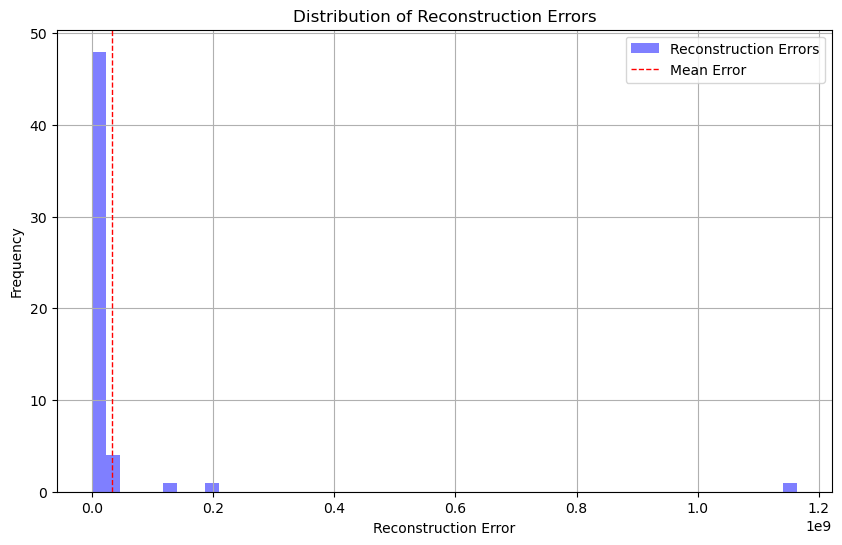

In [ ]:
# Some visualization
# Calculate reconstruction error for each data point
reconstruction_errors = torch.mean((reconstructions - data)**2, dim=1).detach().numpy()

# Plot the distribution of reconstruction errors
plt.figure(figsize=(10, 6))
plt.hist(reconstruction_errors, bins=50, alpha=0.5, color='blue', label='Reconstruction Errors')
plt.axvline(np.mean(reconstruction_errors), color='red', linestyle='dashed', linewidth=1, label='Mean Error')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Distribution of Reconstruction Errors')
plt.legend()
plt.grid(True)
plt.show()